1. Creamos una funcion que nos devuelva la informacion de la API en un dataframe.

Asignamos 30 segundos de espera cuando se ha llegado al limite de solicitudes a la API.

In [233]:
import requests
import pandas as pd
import mysql.connector
from mysql.connector import Error
import time
# creo una funcion que cargue a un data frame el resultado de la api
def carga_df_desde_url(url):
    try:
        # Realiza una solicitud GET a la API
        response = requests.get(url)
        # Verifica si la solicitud fue exitosa (código de estado 200)
        if response.status_code == 200:
           data = response.json()
           # Crea un DataFrame a partir de los datos JSON
           df_carga = pd.DataFrame(data)
           return df_carga,""
        else:
            while response.status_code == 429:
                print("En espera")
                time.sleep(30)
                response = requests.get(url)
                if response.status_code == 200:
                    data = response.json()
                    # Crea un DataFrame a partir de los datos JSON
                    df_carga = pd.DataFrame(data)
                    return df_carga,""
            print(f"Error en la solicitud: Código de estado {response.status_code}")
            return None,"Error"
    except Exception as e:
        print(f"Error: {e}")
        return None, "Error"

2. Definimos estructuras y variables

+ coins_selected : criptomonedas seleccionadas para el analisis. Tal como se ha explicado en el readme, estamos tomando la informacion de CoinGecko con las criptomonedas que mas ganaron(5) y las que mas perdieron(5) haciendo un total de 10 criptomonedas.
+ coin_names : Nombres de las criptomonedas
+ mov_type: tipo registro con Ganancia o Perdida
+ price: lista de precios
+ percenage: Porcentaje
+ df_coins_selected : tabla maestra de monedas

In [235]:
# cargamos manualmente informacion de las criptomonedas seleccionadas

coins_selected = ['harrypotterobamasonic10in','t-mac-dao', 'osaka-protocol','agoric','aioz-network', 'zambesigold', 
            'dust-protocol', 'dagger', 'brick','mevfree']
coin_names = ['HarryPotterObamaSonic10Inu (ETH)','T-mac DAO', 'Osaka Protocol','Agoric','AIOZ Network', 'ZambesiGold', 
                'Dust Protocol', 'Dagger', 'r/FortNiteBR Bricks','MEVFree']
mov_type = ['Gain','Gain','Gain','Gain','Gain','Lose','Lose','Lose','Lose','Lose']
price = [0.158511, 20.87, 0.000000050677, 0.162672, 0.01756175, 0.225813, 1.36, 0.190298, 0.01204557, 0.345769]
percentage = [36.9, 27.8, 23.8, 10.1, 26.6, -30.7, -23.8, -21.9, -16.9, -14.4]
symbol = ['bitcoin','tmg','osak','bld','aioz','zgd','dust','xdag','brick','mevfree']
data = {
    'id_coin': coins_selected,
    'name': coin_names,
    'symbol': symbol,
    'move_type': mov_type,
    'price': price,
    'percentage': percentage}
df_coins_selected = pd.DataFrame(data)
df_coins_selected


,id_coin,name,symbol,move_type,price,percentage
0,harrypotterobamasonic10in,HarryPotterObamaSonic10Inu (ETH),bitcoin,Gain,1.585110e-01,36.9
1,t-mac-dao,T-mac DAO,tmg,Gain,2.087000e+01,27.8
2,osaka-protocol,Osaka Protocol,osak,Gain,5.067700e-08,23.8
3,agoric,Agoric,bld,Gain,1.626720e-01,10.1
4,aioz-network,AIOZ Network,aioz,Gain,1.756175e-02,26.6
5,zambesigold,ZambesiGold,zgd,Lose,2.258130e-01,-30.7
6,dust-protocol,Dust Protocol,dust,Lose,1.360000e+00,-23.8
7,dagger,Dagger,xdag,Lose,1.902980e-01,-21.9
8,brick,r/FortNiteBR Bricks,brick,Lose,1.204557e-02,-16.9
9,mevfree,MEVFree,mevfree,Lose,3.457690e-01,-14.4


3. Cargamos Informacion de las criptomonedas: Coins, coins_x_platform, precios.

Se carga desde la API, se guarda en dataframes.

In [245]:
# 3.1. Funcion carga_coins: COINS y COINS_X_PLATFORM
def carga_coins():
    df_coins, error = carga_df_desde_url ('https://api.coingecko.com/api/v3/coins/list?include_platform=true')
    df_coins.rename(columns={'id': 'id_coin'}, inplace=True)
    df_coins_x_platform = df_coins[['id_coin', 'platforms']]
    # retiramos el campo platforms de df_coins
    df_coins = df_coins.drop('platforms', axis=1)
    # cargamos el df_coins_x_platform        
    records = []
    for index, row in df_coins_x_platform.iterrows():
        id_value = row['id_coin']
        platforms_dict = row['platforms']
        for platform in platforms_dict.items():
            records.append({'id_coin': id_value, 'platform': platform})
    # Volvemos a cargar df_coins_x_platform
    df_coins_x_platform = pd.DataFrame(records)
    #df_coins_x_platform['platform_fixed'] = df_coins_x_platform['platform'].apply(lambda x:x.replace('(','').replace(')','').split(',')[0] )
    df_coins_x_platform['token'] = df_coins_x_platform['platform'].apply(lambda x:x[1] )
    df_coins_x_platform['platform'] = df_coins_x_platform['platform'].apply(lambda x:x[0] )
    return df_coins, df_coins_x_platform

In [381]:
# 3.2. Funcion carga_precios: Cargamos Precios 
import datetime
fecha_inicial = datetime.datetime(2022, 1, 1)
fecha_final = datetime.datetime(2023, 7, 31)
fecha_inicial_unix = fecha_inicial.timestamp()
fecha_final_unix = fecha_final.timestamp()
def carga_precios():
    count=0
    count_global=0
    error = ""
    df_carga = pd.DataFrame(columns=['id_coin', 'date', 'price']) 
    for id_coin in df_coins_selected['id_coin'][df_coins_selected['id_coin'].isin(coins_selected)]:
        df_precio_carga, error = carga_df_desde_url ('https://api.coingecko.com/api/v3/coins/'+id_coin+'/market_chart/range?vs_currency=usd&from='+str(fecha_inicial_unix)+'&to='+str(fecha_final_unix)+'&precision=full')
        if error == "":
            print('cargo el df de precios')
        df_precio_carga['id_coin'] = id_coin
        #df_precio_carga_orig = df_precio_carga
        # extraemos la fecha
        df_precio_carga['date'] = df_precio_carga['prices'].apply(lambda x: int(x[0])) 
        df_precio_carga['fecha_fixed'] = df_precio_carga['date'].apply(lambda x: datetime.date.fromtimestamp(int(x)/1000))
        # extraemos el precio, market_caps, y total volumes de las columnas que contienen listas, en columnas de trabajo 
        df_precio_carga['price'] = df_precio_carga['prices'].apply(lambda x: x[1]) 
        df_precio_carga['market_caps_fixed'] = df_precio_carga['market_caps'].apply(lambda x: x[1])
        df_precio_carga['total_volumes_fixed'] = df_precio_carga['total_volumes'].apply(lambda x: x[1]) 
        # eliminamos las columnas originales
        df_precio_carga = df_precio_carga.drop('prices', axis=1)
        df_precio_carga = df_precio_carga.drop('date', axis=1)
        df_precio_carga = df_precio_carga.drop('market_caps', axis=1)
        df_precio_carga = df_precio_carga.drop('total_volumes', axis=1)
        # asignamos los valores finales
        df_precio_carga['date']= df_precio_carga['fecha_fixed']
        df_precio_carga['market_caps']= df_precio_carga['market_caps_fixed']
        df_precio_carga['total_volumes']= df_precio_carga['total_volumes_fixed']
        # eliminamos las columnas fixed, de trabajo
        df_precio_carga = df_precio_carga.drop('fecha_fixed', axis=1)
        df_precio_carga = df_precio_carga.drop('market_caps_fixed', axis=1)
        df_precio_carga = df_precio_carga.drop('total_volumes_fixed', axis=1)
        df_carga = pd.concat([df_carga, df_precio_carga], ignore_index=True)
    return df_carga

In [315]:
# 3.3. Carga informacion global
def carga_info_global():
    #3. GLOBAL
    # URL de la API que deseas invocar 
    df_global, error = carga_df_desde_url ('https://api.coingecko.com/api/v3/global')
    df_mcp = pd.DataFrame(df_global.loc['market_cap_percentage']) # guardamos aqui los porcentajes
    df_mct = pd.DataFrame(df_global.loc['total_market_cap']) # guardamos aqui los totales
    df_global = df_global.T
    df_global = df_global.drop('market_cap_percentage', axis=1) # eliminamos la columna que hemos pasado a otro DF
    df_global = df_global.drop('total_market_cap', axis=1) # eliminamos la columna que hemos pasado a otro DF
    df_gmcap_perc = pd.DataFrame({'market': df_mcp['market_cap_percentage'][0].keys(), 'percentage': df_mcp['market_cap_percentage'][0].values()})
    df_gmcap_total = pd.DataFrame({'market': df_mct['total_market_cap'][0].keys(), 'total_mc': df_mct['total_market_cap'][0].values()})

    #3. GLOBAL DESCENTRALCED DEFI
    # URL de la API que deseas invocar 
    df_global_defi = carga_df_desde_url ('https://api.coingecko.com/api/v3/global/decentralized_finance_defi')
    df_gdefi = pd.DataFrame(df_global_defi[0]).T
    return df_global, df_gmcap_perc, df_gmcap_total, df_gdefi

4. Insertamos la informacion en la base de datos CRYPTO en MYSQL

In [416]:
# 4. Ahora insertamos la data en mysql
# Información de conexión a la base de datos
def inserta_en_mysql():
    connection_config={
    'host' : 'localhost',
    'user' : 'root',
    'password' : '123456',
    'database' : 'crypto'}
    try:
        connection = mysql.connector.connect(**connection_config)
        if connection.is_connected():
            delete_query = "Delete from coins where 1 = 1"
            cursor = connection.cursor()
            cursor.execute(delete_query)
            delete_query = "Delete from coins_selected where 1 = 1"
            cursor = connection.cursor()
            cursor.execute(delete_query)            
            delete_query = "Delete from coins_x_platform where 1 = 1"
            cursor = connection.cursor()
            delete_query = "Delete from prices where 1 = 1"
            cursor = connection.cursor()    
            cursor.execute(delete_query)
            # Confirma los cambios en la base de datos
            connection.commit()
    except Exception as e:
        print(f"Error: {e}")
    try:
        # Conéctate a la base de datos
        connection = mysql.connector.connect(**connection_config)
        if connection.is_connected():
            print("conexion exitosa")
            table_name = 'coins'
            cursor = connection.cursor()    
            # Genera la consulta para insertar los datos desde el DataFrame
            placeholders = ', '.join(['%s'] * len(df_coins_carga.columns))
            columns = ', '.join(df_coins_carga.columns)
            sql = f"INSERT INTO {table_name} ({columns}) VALUES ({placeholders})"

            # Inserta los datos en la tabla
            values = [tuple(row) for _, row in df_coins_carga.iterrows()]
            cursor.executemany(sql, values)

            # Confirma los cambios en la base de datos
            connection.commit()
            print('se cargo tabla coin')
    except Exception as e:
        print(f"Error: {e}")
    try:
        # Conéctate a la base de datos
        connection = mysql.connector.connect(**connection_config)
        if connection.is_connected(): 
            table_name = 'coins_selected'
            cursor = connection.cursor()    
            # Genera la consulta para insertar los datos desde el DataFrame
            placeholders = ', '.join(['%s'] * len(df_coins_selected.columns))
            columns = ', '.join(df_coins_selected.columns)
            sql = f"INSERT INTO {table_name} ({columns}) VALUES ({placeholders})"

            # Inserta los datos en la tabla
            values = [tuple(row) for _, row in df_coins_selected.iterrows()]
            cursor.executemany(sql, values)

            # Confirma los cambios en la base de datos
            connection.commit()
            print('se cargo tabla coins_selected')
    except Exception as e:
        print(f"Error: {e}")        
    try:
        if connection.is_connected():
            table_name = 'coins_x_platform'
            cursor = connection.cursor()    
            # Genera la consulta para insertar los datos desde el DataFrame
            placeholders = ', '.join(['%s'] * len(df_coins_x_platform_carga.columns))
            columns = ', '.join(df_coins_x_platform_carga.columns)
            sql = f"INSERT INTO {table_name} ({'id_coin,id_platform,id_token'}) VALUES ({placeholders})"

            # Inserta los datos en la tabla
            values = [tuple(row) for _, row in df_coins_x_platform_carga.iterrows()]
            cursor.executemany(sql, values)

            # Confirma los cambios en la base de datos
            connection.commit()
            print('se cargo tabla coin_x_platform')
    except Exception as e:
        print(f"Error: {e}")
    try:
        if connection.is_connected():
            table_name = 'prices'
            cursor = connection.cursor()    
            # Genera la consulta para insertar los datos desde el DataFrame
            placeholders = ', '.join(['%s'] * len(df_prices_carga.columns))
            columns = ', '.join(df_prices_carga.columns)
            sql = f"INSERT INTO {table_name} ({'id_coin,date,price,market_caps, total_volumes'}) VALUES ({placeholders})"

            # Inserta los datos en la tabla
            values = [tuple(row) for _, row in df_prices_carga.iterrows()]
            cursor.executemany(sql, values)

            # Confirma los cambios en la base de datos
            connection.commit()
            print('se cargo tabla prices')
    except Exception as e:
        print(f"Error: {e}")        
    return True

conexion exitosa
se cargo tabla coin
se cargo tabla coins_selected
se cargo tabla coin_x_platform
se cargo tabla prices


True

5. Ejecutamos la carga de datos hacia dataframes

In [375]:
# invocamos a las funciones de carga
df_coins_carga, df_coins_x_platform_carga = carga_coins()
df_prices_carga = carga_precios()
df_global_carga, df_gmcp_carga, df_gmct_carga, df_global_defi = carga_info_global()


6. Ejecutamos la carga en MYSQL

In [418]:
inserta_en_mysql()

conexion exitosa
se cargo tabla coin
se cargo tabla coins_selected
se cargo tabla coin_x_platform
se cargo tabla prices


True

6. Realizamos el EDA

Exploramos la data antes de cargarla a MYSQL

6.1. La informacion de precios que hemos elegido nos arroja un total de 3404 filas no nulas

Las fechas van del 01/01/2022 al 31/07/2023, son 576 dias


In [249]:
# 6.1
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
print(df_prices_carga.info())
print(df_prices_carga.describe())
df_coins_selected 
 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3404 entries, 0 to 3403
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id_coin        3404 non-null   object 
 1   date           3404 non-null   object 
 2   price          3404 non-null   float64
 3   market_caps    3404 non-null   float64
 4   total_volumes  3404 non-null   float64
dtypes: float64(3), object(2)
memory usage: 133.1+ KB
None
              price   market_caps  total_volumes
count  3.404000e+03  3.404000e+03   3.404000e+03
mean   7.868775e-01  2.028305e+07   4.575536e+05
std    2.070482e+00  3.462395e+07   1.414482e+06
min    1.292247e-08  0.000000e+00   0.000000e+00
25%    1.489117e-02  0.000000e+00   1.589848e+04
50%    8.278451e-02  7.592495e+05   1.183354e+05
75%    5.118676e-01  2.294706e+07   4.489748e+05
max    2.158472e+01  1.715461e+08   3.021671e+07


,id_coin,name,symbol,move_type,price,percentage
0,harrypotterobamasonic10in,HarryPotterObamaSonic10Inu (ETH),bitcoin,Gain,1.585110e-01,36.9
1,t-mac-dao,T-mac DAO,tmg,Gain,2.087000e+01,27.8
2,osaka-protocol,Osaka Protocol,osak,Gain,5.067700e-08,23.8
3,agoric,Agoric,bld,Gain,1.626720e-01,10.1
4,aioz-network,AIOZ Network,aioz,Gain,1.756175e-02,26.6
5,zambesigold,ZambesiGold,zgd,Lose,2.258130e-01,-30.7
6,dust-protocol,Dust Protocol,dust,Lose,1.360000e+00,-23.8
7,dagger,Dagger,xdag,Lose,1.902980e-01,-21.9
8,brick,r/FortNiteBR Bricks,brick,Lose,1.204557e-02,-16.9
9,mevfree,MEVFree,mevfree,Lose,3.457690e-01,-14.4



6.2. Encontramos 3 criptomonedas que tienen menos de 4 meses de informacion:

+ Osaka Protocol (Del grupo de ganacias), hemos investigado que fue lanzada en ABRIL-2023
+ HarryPotterObamaSonic10Inu (ETH) (Del grupo de Ganancias), lanzada en NOVIEMBRE-2021
+ MEVFree (Del grupo de Perdidas), lanzada el 2022

Posteriormente se puede indagar sobre las diversas razones por las que se presentan fechas sin precios, o elegir otro juego de criptomonedas que presenten precios en todas las fechas.
Vamos a tomar solamente los datos de precios que hemos obtenido con la API.

In [253]:
import pandas as pd

# Count records for each id using a join and groupby
id_counts = df_prices_carga.groupby('id_coin').size().reset_index(name='record_count')

# Merge with df_coins_selected to include all ids
result = df_coins_selected.merge(id_counts, on='id_coin', how='left')

result.sort_values(by='record_count', ascending=True)

,id_coin,name,symbol,move_type,price,percentage,record_count
2,osaka-protocol,Osaka Protocol,osak,Gain,5.067700e-08,23.8,25
0,harrypotterobamasonic10in,HarryPotterObamaSonic10Inu (ETH),bitcoin,Gain,1.585110e-01,36.9,78
9,mevfree,MEVFree,mevfree,Lose,3.457690e-01,-14.4,133
1,t-mac-dao,T-mac DAO,tmg,Gain,2.087000e+01,27.8,266
3,agoric,Agoric,bld,Gain,1.626720e-01,10.1,336
5,zambesigold,ZambesiGold,zgd,Lose,2.258130e-01,-30.7,433
8,brick,r/FortNiteBR Bricks,brick,Lose,1.204557e-02,-16.9,476
6,dust-protocol,Dust Protocol,dust,Lose,1.360000e+00,-23.8,505
4,aioz-network,AIOZ Network,aioz,Gain,1.756175e-02,26.6,576
7,dagger,Dagger,xdag,Lose,1.902980e-01,-21.9,576


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3404 entries, 0 to 3403
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id_coin        3404 non-null   object        
 1   date           3404 non-null   datetime64[ns]
 2   price          3404 non-null   float64       
 3   market_caps    3404 non-null   float64       
 4   total_volumes  3404 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 133.1+ KB
None
                                date         price   market_caps   
count                           3404  3.404000e+03  3.404000e+03  \
mean   2022-12-11 06:34:15.934195456  7.868775e-01  2.028305e+07   
min              2022-01-01 00:00:00  1.292247e-08  0.000000e+00   
25%              2022-08-14 00:00:00  1.489117e-02  0.000000e+00   
50%              2023-01-01 12:00:00  8.278451e-02  7.592495e+05   
75%              2023-04-28 00:00:00  5.118676e-01 

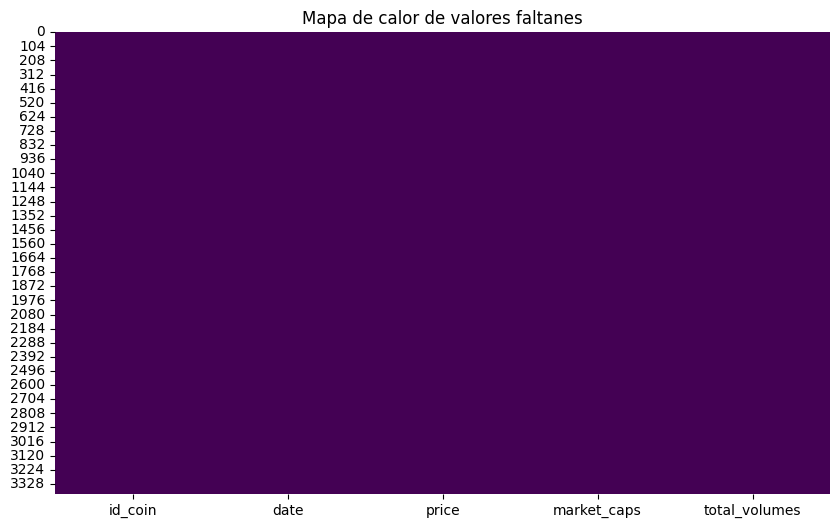

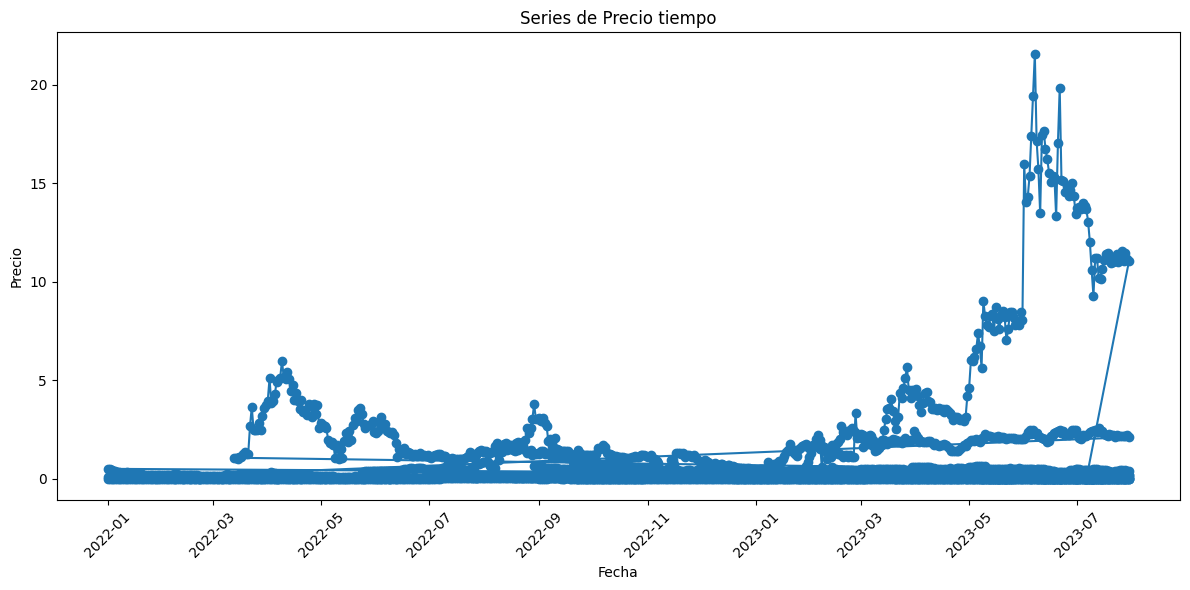

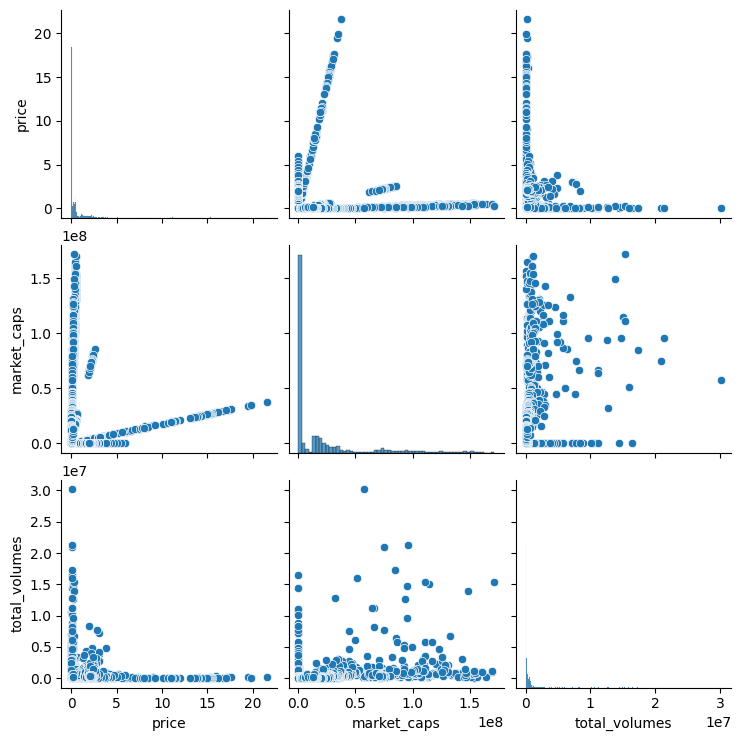

In [271]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your DataFrame (replace 'your_data.csv' with your actual data source)
# df_prices_carga = pd.read_csv('your_data.csv')

# Display basic information about the DataFrame
print(df_prices_carga.info())
print(df_prices_carga.describe())

# Calculate missing values
missing_values = df_prices_carga.isnull().sum()
print("Missing values:")
print(missing_values)

# Visualize missing values using a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_prices_carga.isnull(), cmap="viridis", cbar=False)
plt.title("Mapa de calor de valores faltantes")
plt.show()

# Plot time series of prices
plt.figure(figsize=(12, 6))
plt.plot(df_prices_carga['date'], df_prices_carga['price'], marker='o')
plt.xlabel("Fecha")
plt.ylabel("Precio")
plt.title("Series de Precio tiempo")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create a pair plot for correlation analysis
sns.pairplot(df_prices_carga[['price', 'market_caps', 'total_volumes']])
plt.show()

Al revisar este grafico, notamos que solo 2 criptomonedas de la lista tienen un precio > 1 USD.

Sera necesario analizar el volumen, o el porcentaje respecto al total del mercado.

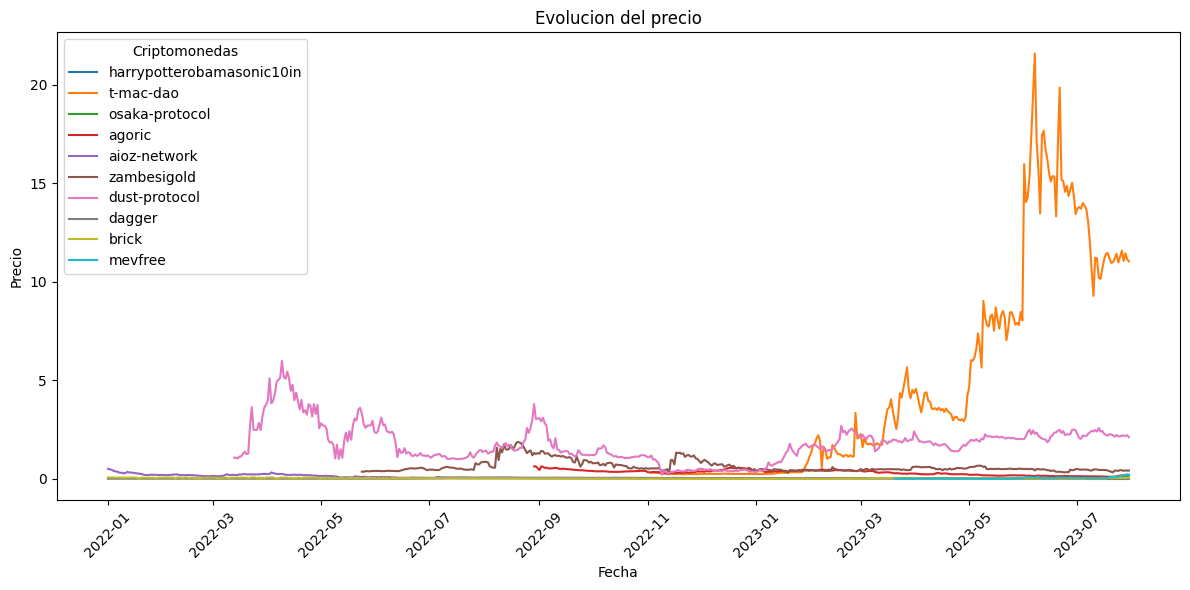

In [270]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure and axis
plt.figure(figsize=(12, 6))

# Create a line plot with multiple lines
sns.lineplot(data=df_prices_carga, x='date', y='price', hue='id_coin')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.title('Evolucion del precio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='Criptomonedas')

plt.show()

La informacion de criptomonedas seleccionadas por plataforma tiene 5 registros asociados a ETHEREUM, y Dust Protocol esta
asociada a 3 plataformas. 

In [285]:
df_coins_x_platform_carga[df_coins_x_platform_carga['id_coin'].isin(df_coins_selected['id_coin'])].sort_values(by='id_coin', ascending=True)

,id_coin,platform,token
336,agoric,osmosis,ibc/2DA9C149E9AD2BD27FEFA635458FB37093C256C1A9...
360,aioz-network,ethereum,0x626e8036deb333b408be468f951bdb42433cbf18
361,aioz-network,binance-smart-chain,0x33d08d8c7a168333a85285a68c0042b39fc3741d
1802,brick,arbitrum-nova,0x6dcb98f460457fe4952e12779ba852f82ecc62c1
3506,dust-protocol,ethereum,0xb5b1b659da79a2507c27aad509f15b4874edc0cc
3507,dust-protocol,solana,DUSTawucrTsGU8hcqRdHDCbuYhCPADMLM2VcCb8VnFnQ
3508,dust-protocol,polygon-pos,0x4987a49c253c38b3259092e9aac10ec0c7ef7542
4840,harrypotterobamasonic10in,ethereum,0x72e4f9f808c49a2a61de9c5896298920dc4eeea9
6719,mevfree,ethereum,0x1936c91190e901b7dd55229a574ae22b58ff498a
7709,osaka-protocol,ethereum,0xa21af1050f7b26e0cff45ee51548254c41ed6b5c


In [287]:
df_coins_carga

,id_coin,symbol,name
0,01coin,zoc,01coin
1,0chain,zcn,Zus
2,0vix-protocol,vix,0VIX Protocol
3,0x,zrx,0x Protocol
4,0x0-ai-ai-smart-contract,0x0,0x0.ai: AI Smart Contract
...,...,...,...
10050,zynecoin,zyn,Zynecoin
10051,zynergy,zyn,Zynergy
10052,zyrri,zyr,Zyrri
10053,zyx,zyx,ZYX


6. Ejecutamos la carga de datos hacia MYSQL

En la base de datos CRYPTO tenemos las tablas que vana recibir la informacion de los dataframes

In [ ]:
# Finalmente llevamos la informacion a la bd CRYPTO en mysql, donde ya hemos creado las tablas 
inserta_en_mysql()

In [213]:
 
df_global_defi

,defi_dominance,defi_market_cap,defi_to_eth_ratio,eth_market_cap,top_coin_defi_dominance,top_coin_name,trading_volume_24h
data,3.82641335368489902244697636187025529668475276...,46479820689.1287753911977342316,21.0228297950504525242293847946444154266498656...,221092122907.6013115023106025674,32.126534,Lido Staked Ether,1551581342.184856201391665241466


6. Cargamos informacion de precios de las criptomonedas

Los valores de fecha, precios, market_caps, y total_volume se encuentran anidados en listas dentro de las columnas.

La columna market_caps tiene valores en Cero, lo que puede considerarse como criptomonedas poco confiables, errores de data, poco tiempo en el mercado, errores de calculo, entre otros.

